In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
import prep
#import model


#### Acquire and prep
consolidate all the csv files, delete the nutrition related data. 

In [2]:
df= acquire.get_df()
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [3]:
df= prep.prep_df()
target_vars=['Steps']
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


#### Split Data

In [4]:
train, test= prep.test_train_split(df, .66)
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 148
Testing Observations: 77


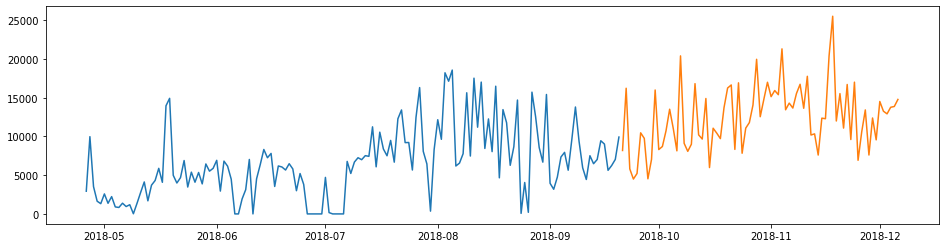

In [5]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

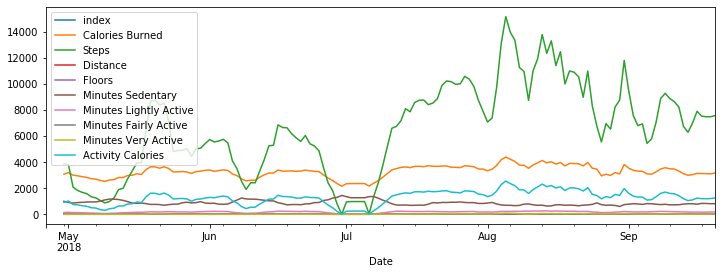

In [6]:
#Moving Average
train.rolling(5).mean().plot(figsize=(12, 4))
plt.show()

### Last observed value

In [7]:
yhat = pd.DataFrame(test[target_vars])
for var in target_vars:
    yhat[var] = int(train[var][-1:])
yhat.head()

,Steps
Date,
2018-09-21,9920
2018-09-22,9920
2018-09-23,9920
2018-09-24,9920
2018-09-25,9920


In [8]:
for var in target_vars:
    print(var, ":", yhat[var].min() == yhat[var].max())

Steps : True


In [28]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()
    
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


Steps -- MSE: 31151561.26 RMSE: 5581.36


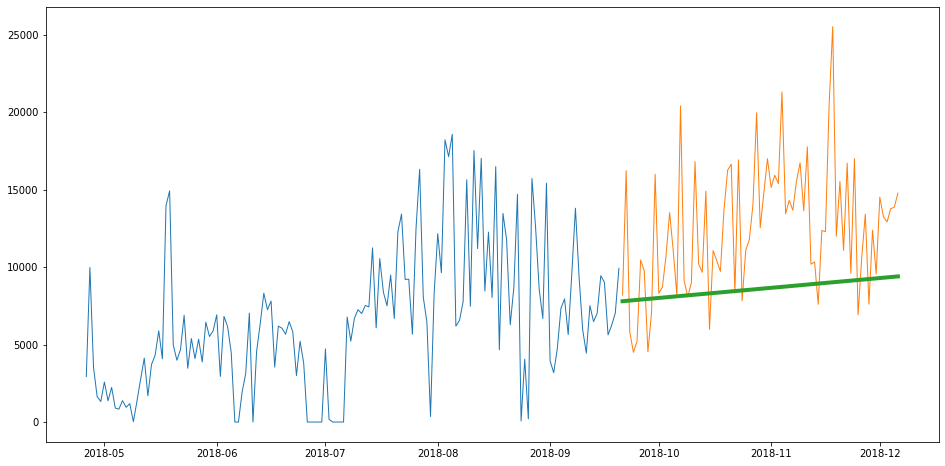

In [29]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

In [30]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_vars=target_vars, train = train, test = test)

#### Simple Average

In [31]:
for var in target_vars:
    yhat[var] = train[var].mean()

Steps -- MSE: 53133261.42 RMSE: 7289.26


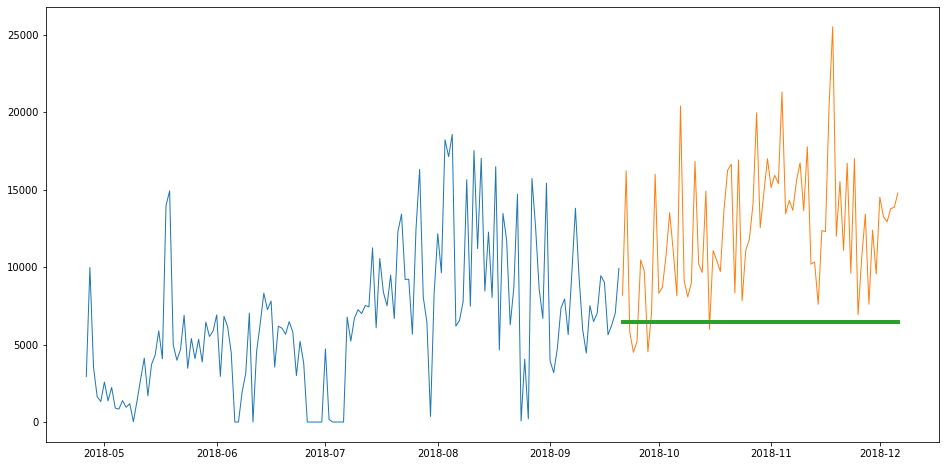

In [32]:
plot_and_eval(target_vars, train = train, test = test)

#### Moving Average

In [33]:
periods = 12
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

Steps -- MSE: 43590772.51 RMSE: 6602.33


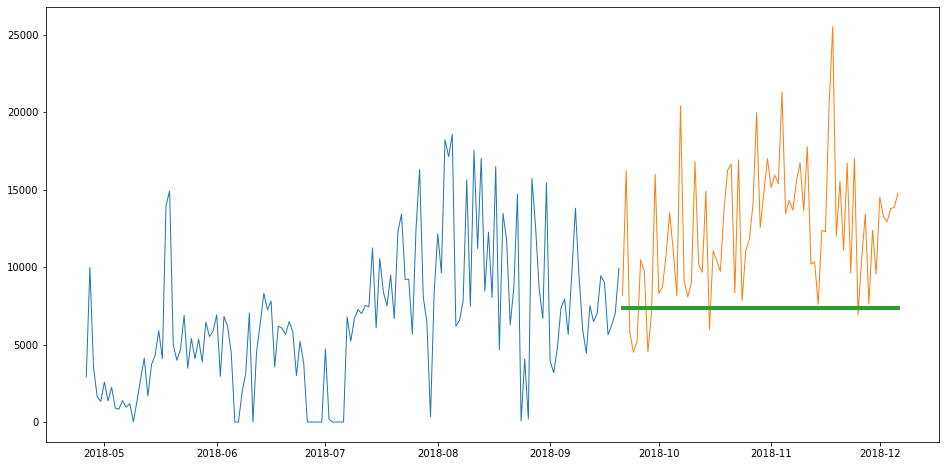

In [34]:
plot_and_eval(target_vars, train = train, test = test)

### Holt's Linear Trend

Steps 



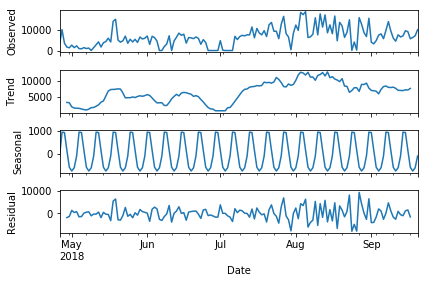

In [35]:
import statsmodels.api as sm

for var in target_vars:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var].resample('D').mean()).plot()
    plt.show()

### Fit Basic Holt's Linear Trend Model

Steps -- MSE: 31151561.26 RMSE: 5581.36


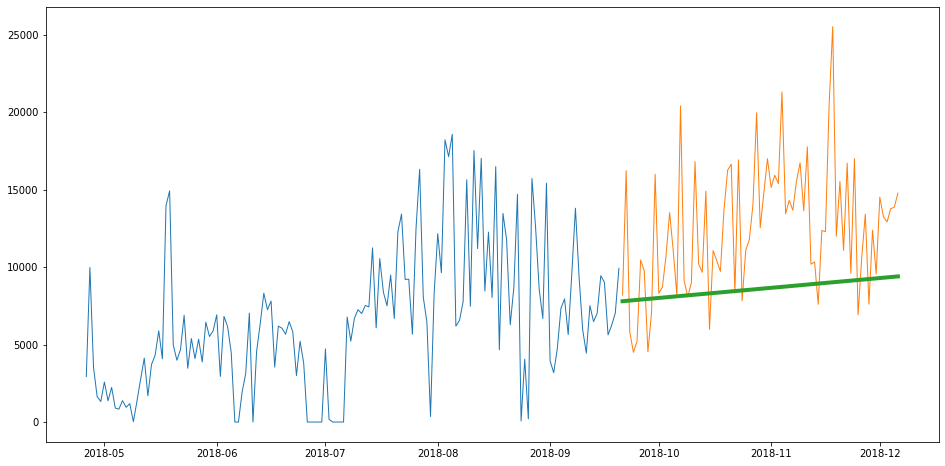

In [36]:
from statsmodels.tsa.api import Holt

for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)